In [333]:
# making the cramer rao lower bound plots
# essentially, how well you can constrain the position of something is given by how much its gradient changes
# first, we need to generate airy disc and toliman psfs. 

# but before that, get our imports done
import dLux as dl
import dLuxToliman as dlT
# gonna use normal numpy. jax numpy is weird. sike using jax
import numpy as np
from matplotlib import pyplot as plt
import dLux.utils as dlu
import jax
import jax.random as jr
import jax.numpy as jnp

# let's create the toliman pupil and obstructions, call it tolOptics

# might as well use 1024 pixels wavefront. nice and large number, prevent aliasing
wf_npixels = 1024

# similar
psf_npixels = 128

# no need for oversampling
oversample = 2 # can change, put to 1 for normal toliman

# toliman pixel scale
psf_pixel_scale = 0.375

tolOptics = dlT.TolimanOpticalSystem(wf_npixels, psf_npixels, oversample, psf_pixel_scale)

# now let's extract the pupil
tolPupil = tolOptics.pupil.opd

# make it a nice phase difference instead of OPD
tolPupilPhase = dlu.opd2phase(tolPupil, 585e-9) # it is pi phase difference for 585e-9 wavelength

# layer
tolPupilLayer = dl.layers.AberratedLayer(phase=tolPupilPhase)

# (normal toliman diameter)
diameter = 0.125

# initialsing coords for circular aperture
coords = dlu.pixel_coords(wf_npixels,diameter)

# x = np.arange(wf_npixels)
# y = np.arange(wf_npixels)
# X, Y = np.meshgrid(x,y, indexing = 'ij') # I believe the indexing part is neccessary? Anyway doesn't break anything

# creating the aperture (circular)
airyAperture = dlu.circle(coords,0.5 * diameter)

# making it a layer
airyApertureLayer = dl.layers.TransmissiveLayer(transmission=airyAperture, normalise=True)

# making the optical systems
tolPupilLayers = [
    (
        'aperture',
        airyApertureLayer
    ),
    (
        'pupil',
        tolPupilLayer
    )
]

airyApertureLayers = [
    (
        'aperture',
        airyApertureLayer
    )
]

tolPupilSystem = dl.AngularOpticalSystem(wf_npixels, diameter, tolPupilLayers, psf_npixels, psf_pixel_scale, oversample)

airyApertureSystem = dl.AngularOpticalSystem(wf_npixels, diameter, airyApertureLayers, psf_npixels, psf_pixel_scale, oversample)

In [334]:
# need to create scipy hamming blurring function (thanks chatgpt)
from scipy.signal import convolve2d

def hamming_blur(image, size=5):
    """Blurs a 2D NumPy array using a Hamming window of given size."""
    # Create a 1D Hamming window
    hamming_1d = jnp.hamming(size)
    
    # Generate a 2D Hamming window using outer product
    hamming_2d = jnp.outer(hamming_1d, hamming_1d)
    
    # Normalize kernel to preserve brightness
    hamming_2d /= jnp.sum(hamming_2d)

    # Perform 2D convolution with 'same' padding
    blurred = convolve2d(image, hamming_2d, mode='same', boundary='symm')

    return blurred

In [335]:
n_sources = 50
max_pos = 18 #arcseconds
positions_arcsecs = jr.uniform(jr.PRNGKey(0), (n_sources, 2), minval=-max_pos, maxval=max_pos)  # Generate 10x2 array
positions_rads = dlu.arcsec2rad(positions_arcsecs)
fluxes = jr.uniform(jr.PRNGKey(0), (n_sources,), minval=1, maxval=1)
wavelength = 585e-9
wavelengths = wavelength * jnp.linspace(1, 1, 1)
sources = dl.PointSources(wavelengths,positions_rads,fluxes)

In [336]:
psf = sources.model(tolPupilSystem)

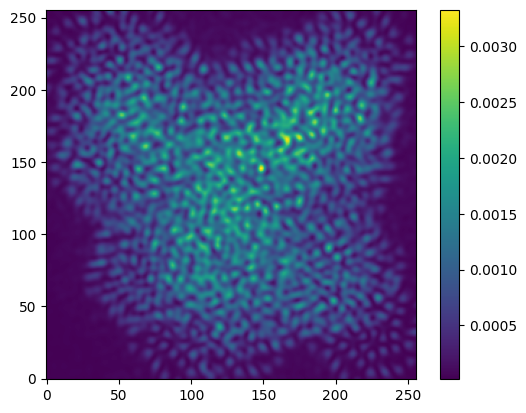

In [337]:
plt.imshow(psf, origin='lower')
plt.colorbar()
plt.show()

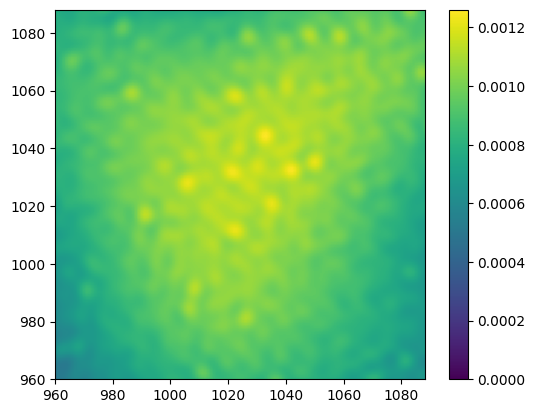

In [344]:
# doing the fourier transform of the image
# have to resize the image (zero padding) to get not have aliasing and stuff
resize_factor = 8*128*oversample
psf_model_ft = jnp.fft.fftshift(jnp.fft.fft2(dlu.resize(tolPupilSystem.propagate_mono(wavelength),resize_factor)))
total_image_ft = jnp.fft.fftshift(jnp.fft.fft2(dlu.resize(psf,resize_factor)))
correlation = jnp.fft.fftshift(jnp.fft.ifft2(psf_model_ft*total_image_ft))
plt.imshow(jnp.abs(correlation),origin='lower')
plt.colorbar()
plt.xlim(resize_factor/2-64,resize_factor/2+64)
plt.ylim(resize_factor/2-64,resize_factor/2+64)
plt.show()
# works

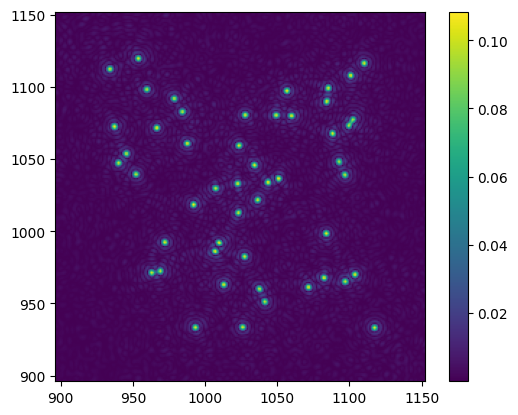

In [345]:
# now try the different/better method:

floor_val = 1e-5 # seems like a decent value
blur_size = 4 # good value, don't make it too high

# need to re add hamming window
floor_vals = jr.uniform(jr.PRNGKey(0), (resize_factor,resize_factor), minval=floor_val, maxval=floor_val)
bessel = jnp.fft.fftshift(jnp.fft.ifft2((total_image_ft*jnp.conjugate(psf_model_ft))/jnp.maximum((jnp.abs(psf_model_ft)**2),floor_vals)))

plt.imshow(jnp.abs(bessel),origin='lower')
plt.xlim(resize_factor/2-64*oversample,resize_factor/2+64*oversample)
plt.ylim(resize_factor/2-64*oversample,resize_factor/2+64*oversample)
plt.colorbar()
plt.show()

# Works very well

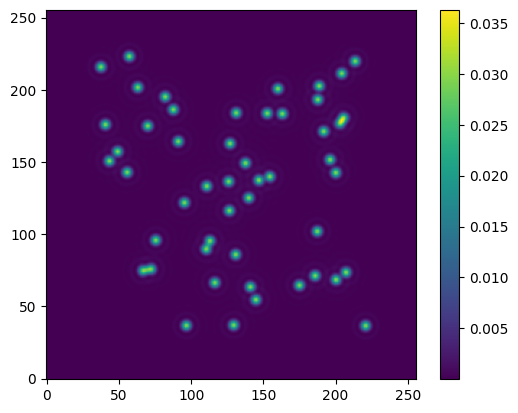

In [342]:
psf_2 = sources.model(airyApertureSystem)
plt.imshow(psf_2,origin='lower')
plt.colorbar()
plt.show()

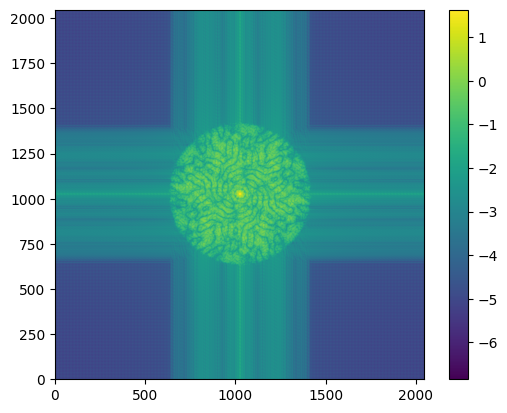

In [340]:
# just a visualisation of the fourier tranform of some stuff
plt.imshow(jnp.log10(jnp.abs(total_image_ft)),origin='lower')
plt.colorbar()
plt.show()